In [0]:
%sh pip install lightgbm

You should consider upgrading via the '/local_disk0/.ephemeral_nfs/envs/pythonEnv-fcd57ee6-5332-4a31-83b9-96a7f2333e5b/bin/python -m pip install --upgrade pip' command.


In [0]:
import pandas as pd
import numpy as np
import seaborn as sns
import mlflow
import mlflow.sklearn
import matplotlib.pyplot as plt
import shap
from lightgbm import LGBMClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import average_precision_score, accuracy_score, auc, classification_report, confusion_matrix, f1_score, plot_confusion_matrix, plot_precision_recall_curve, plot_roc_curve, precision_recall_curve, precision_recall_fscore_support, recall_score, roc_curve, roc_auc_score, precision_score
from sklearn import set_config
from sklearn.pipeline import Pipeline
from sklearn.calibration import calibration_curve

from pprint import pprint

Read in data, drop some columns, and adjust data types

In [0]:
# read in and drop unneeded cols
model_input = pd.read_parquet("/your_path/model_input")
model_input = model_input.drop(["crash_date", "crash_record_id", "injuries_total"], axis=1)

In [0]:
model_input

,crash_month,crash_hour,crash_day_of_week,posted_speed_limit,traffic_control_device,device_condition,weather_condition,lighting_condition,first_crash_type,trafficway_type,...,road_defect,intersection_related_i,prim_contributory_cause,sec_contributory_cause,street_name,latitude,longitude,target,brakes,safety_belt
0,2,2,7,30,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,SNOW,"DARKNESS, LIGHTED ROAD",REAR END,FOUR WAY,...,NO DEFECTS,Y,WEATHER,FOLLOWING TOO CLOSELY,SHERIDAN RD,42.016071,-87.664933,0,0,0
1,2,1,7,40,UNKNOWN,OTHER,SNOW,"DARKNESS, LIGHTED ROAD",REAR END,ONE-WAY,...,UNKNOWN,None,WEATHER,NOT APPLICABLE,LAKE SHORE DR SB,41.893950,-87.615083,0,0,0
2,2,1,7,35,NO CONTROLS,NO CONTROLS,SNOW,"DARKNESS, LIGHTED ROAD",REAR END,NOT DIVIDED,...,NO DEFECTS,Y,FOLLOWING TOO CLOSELY,WEATHER,TOUHY AVE,42.012377,-87.688870,0,0,0
3,2,1,7,10,NO CONTROLS,NO CONTROLS,SNOW,"DARKNESS, LIGHTED ROAD",PARKED MOTOR VEHICLE,NOT DIVIDED,...,NO DEFECTS,None,UNABLE TO DETERMINE,UNABLE TO DETERMINE,63RD ST,41.779000,-87.693788,0,0,0
4,2,1,7,30,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,SNOW,"DARKNESS, LIGHTED ROAD",SIDESWIPE SAME DIRECTION,NOT DIVIDED,...,NO DEFECTS,None,WEATHER,WEATHER,TOUHY AVE,42.012390,-87.690181,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,5,14,1,20,NO CONTROLS,NO CONTROLS,CLEAR,DAWN,PARKED MOTOR VEHICLE,NOT DIVIDED,...,NO DEFECTS,None,IMPROPER BACKING,NOT APPLICABLE,CLAREMONT AVE,41.970012,-87.687884,0,0,0
199996,5,14,1,30,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,CLEAR,DAYLIGHT,SIDESWIPE SAME DIRECTION,NOT DIVIDED,...,NO DEFECTS,Y,FAILING TO YIELD RIGHT-OF-WAY,FAILING TO REDUCE SPEED TO AVOID CRASH,PULASKI RD,41.928039,-87.727020,0,0,0
199997,5,14,1,30,NO CONTROLS,NO CONTROLS,CLEAR,DAYLIGHT,SIDESWIPE SAME DIRECTION,NOT DIVIDED,...,NO DEFECTS,None,IMPROPER LANE USAGE,UNABLE TO DETERMINE,PERSHING RD,41.823732,-87.633266,0,0,0
199998,5,14,1,40,OTHER WARNING SIGN,FUNCTIONING IMPROPERLY,CLEAR,DAYLIGHT,REAR END,DIVIDED - W/MEDIAN BARRIER,...,NO DEFECTS,None,DISREGARDING OTHER TRAFFIC SIGNS,FAILING TO REDUCE SPEED TO AVOID CRASH,LAKE SHORE DR NB,41.985557,-87.653361,0,0,0


In [0]:
model_input.dtypes

Out[6]: crash_record_id                    object
crash_date                 datetime64[ns]
crash_month                         int32
crash_hour                          int32
crash_day_of_week                   int32
posted_speed_limit                  int32
traffic_control_device             object
device_condition                   object
weather_condition                  object
lighting_condition                 object
first_crash_type                   object
trafficway_type                    object
alignment                          object
roadway_surface_cond               object
road_defect                        object
intersection_related_i             object
prim_contributory_cause            object
sec_contributory_cause             object
street_name                        object
injuries_total                    float64
latitude                          float64
longitude                         float64
target                              int32
brakes                    

Set the target and feature columns

In [0]:
target_col = ["target"]
feature_cols = list(set(model_input.columns) - set(target_col))
feature_cols

Out[45]: ['trafficway_type',
 'crash_hour',
 'crash_month',
 'roadway_surface_cond',
 'intersection_related_i',
 'street_name',
 'lighting_condition',
 'sec_contributory_cause',
 'crash_day_of_week',
 'safety_belt',
 'first_crash_type',
 'device_condition',
 'weather_condition',
 'posted_speed_limit',
 'longitude',
 'road_defect',
 'alignment',
 'latitude',
 'brakes',
 'prim_contributory_cause',
 'traffic_control_device']

In [0]:
# convert all object columns to categories
model_input[model_input.select_dtypes("object").columns] = model_input.select_dtypes("object").astype("category")

In [0]:
# check data types
model_input.dtypes

Out[47]: crash_month                   int32
crash_hour                    int32
crash_day_of_week             int32
posted_speed_limit            int32
traffic_control_device     category
device_condition           category
weather_condition          category
lighting_condition         category
first_crash_type           category
trafficway_type            category
alignment                  category
roadway_surface_cond       category
road_defect                category
intersection_related_i     category
prim_contributory_cause    category
sec_contributory_cause     category
street_name                category
latitude                    float64
longitude                   float64
target                        int32
brakes                        int64
safety_belt                   int64
dtype: object

Split data into train, validation, and test sets

In [0]:
split_X = model_input[feature_cols]
split_y = model_input[target_col]

# split out train data
X_train, split_X_rem, y_train, split_y_rem = train_test_split(split_X, split_y, train_size=0.6, random_state=876432273, stratify=split_y)

# split remaining data equally for validation and test
X_val, X_test, y_val, y_test = train_test_split(split_X_rem, split_y_rem, test_size=0.5, random_state=876432273, stratify=split_y_rem)

In [0]:
X_train

,trafficway_type,crash_hour,crash_month,roadway_surface_cond,intersection_related_i,street_name,lighting_condition,sec_contributory_cause,crash_day_of_week,safety_belt,...,device_condition,weather_condition,posted_speed_limit,longitude,road_defect,alignment,latitude,brakes,prim_contributory_cause,traffic_control_device
47290,NOT DIVIDED,18,9,DRY,NaN,CLINTON ST,DAYLIGHT,NOT APPLICABLE,5,2,...,FUNCTIONING PROPERLY,CLEAR,30,-87.640995,NO DEFECTS,STRAIGHT AND LEVEL,41.880205,0,FAILING TO YIELD RIGHT-OF-WAY,STOP SIGN/FLASHER
69978,NOT DIVIDED,12,7,UNKNOWN,NaN,FULTON BLVD,UNKNOWN,UNABLE TO DETERMINE,7,0,...,NO CONTROLS,UNKNOWN,25,-87.715568,UNKNOWN,STRAIGHT AND LEVEL,41.886400,0,UNABLE TO DETERMINE,NO CONTROLS
34040,NOT DIVIDED,18,10,UNKNOWN,NaN,KINGSBURY ST,UNKNOWN,UNABLE TO DETERMINE,4,0,...,UNKNOWN,UNKNOWN,30,-87.639395,UNKNOWN,STRAIGHT AND LEVEL,41.890684,0,UNABLE TO DETERMINE,UNKNOWN
99077,NOT DIVIDED,13,3,UNKNOWN,NaN,CERMAK RD,DAYLIGHT,FOLLOWING TOO CLOSELY,3,0,...,FUNCTIONING PROPERLY,CLEAR,30,-87.702876,UNKNOWN,STRAIGHT AND LEVEL,41.851908,0,FOLLOWING TOO CLOSELY,TRAFFIC SIGNAL
126075,ONE-WAY,6,12,DRY,NaN,FRANKLIN ST,DAWN,FOLLOWING TOO CLOSELY,1,0,...,FUNCTIONING PROPERLY,CLEAR,30,-87.635028,NO DEFECTS,STRAIGHT AND LEVEL,41.876755,0,FOLLOWING TOO CLOSELY,TRAFFIC SIGNAL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110773,NOT DIVIDED,13,2,DRY,NaN,YALE AVE,DAYLIGHT,UNABLE TO DETERMINE,3,0,...,NO CONTROLS,CLEAR,20,-87.631928,NO DEFECTS,STRAIGHT AND LEVEL,41.777987,0,UNABLE TO DETERMINE,NO CONTROLS
141446,DIVIDED - W/MEDIAN BARRIER,8,10,WET,NaN,CHICAGO SKYWAY IB,DAYLIGHT,WEATHER,6,0,...,NO CONTROLS,RAIN,45,-87.627650,NO DEFECTS,"CURVE, LEVEL",41.775405,0,EQUIPMENT - VEHICLE CONDITION,NO CONTROLS
199674,NOT DIVIDED,13,5,DRY,NaN,LARAMIE AVE,DAYLIGHT,UNABLE TO DETERMINE,2,0,...,UNKNOWN,CLEAR,30,-87.755971,NO DEFECTS,STRAIGHT AND LEVEL,41.904432,0,FAILING TO REDUCE SPEED TO AVOID CRASH,NO CONTROLS
106911,NOT DIVIDED,22,2,DRY,NaN,LOOMIS BLVD,"DARKNESS, LIGHTED ROAD",UNABLE TO DETERMINE,2,0,...,NO CONTROLS,CLEAR,30,-87.659613,NO DEFECTS,STRAIGHT AND LEVEL,41.783831,0,PHYSICAL CONDITION OF DRIVER,NO CONTROLS


In [0]:
# create a list of the categorical columns
categorical_cols = X_train.select_dtypes("category").columns.to_list()

In [0]:
categorical_cols

Out[51]: ['trafficway_type',
 'roadway_surface_cond',
 'intersection_related_i',
 'street_name',
 'lighting_condition',
 'sec_contributory_cause',
 'first_crash_type',
 'device_condition',
 'weather_condition',
 'road_defect',
 'alignment',
 'prim_contributory_cause',
 'traffic_control_device']

Fit model, predict on validation and test set, log run to MLFlow for experiment tracking

In [0]:
from time import time
with mlflow.start_run(experiment_id="3645939023888189", run_name="lightgbm") as run:
  model = LGBMClassifier()

  # Enable automatic logging of input samples, metrics, parameters, and models
  mlflow.lightgbm.autolog(
      log_input_examples=True,
      silent=True)
  
  start = time()
  model.fit(X_train, y_train)
  
  y_val_pred = model.predict(X_val)
  y_test_pred = model.predict(X_test)
  
  end = time()
  
  mlflow.log_metric("n_train", y_train.shape[0])
  mlflow.log_metric("f1_val", f1_score(y_val, y_val_pred))
  mlflow.log_metric("f1_test", f1_score(y_test, y_test_pred))
  mlflow.log_metric("duration", end - start)

/databricks/python/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


In [0]:
print(classification_report(y_val, y_val_pred))

              precision    recall  f1-score   support

           0       0.88      0.98      0.93     33996
           1       0.74      0.26      0.38      6004

    accuracy                           0.88     40000
   macro avg       0.81      0.62      0.66     40000
weighted avg       0.86      0.88      0.85     40000



In [0]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.88      0.98      0.93     33996
           1       0.74      0.25      0.37      6004

    accuracy                           0.87     40000
   macro avg       0.81      0.62      0.65     40000
weighted avg       0.86      0.87      0.85     40000



Check feature importance

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


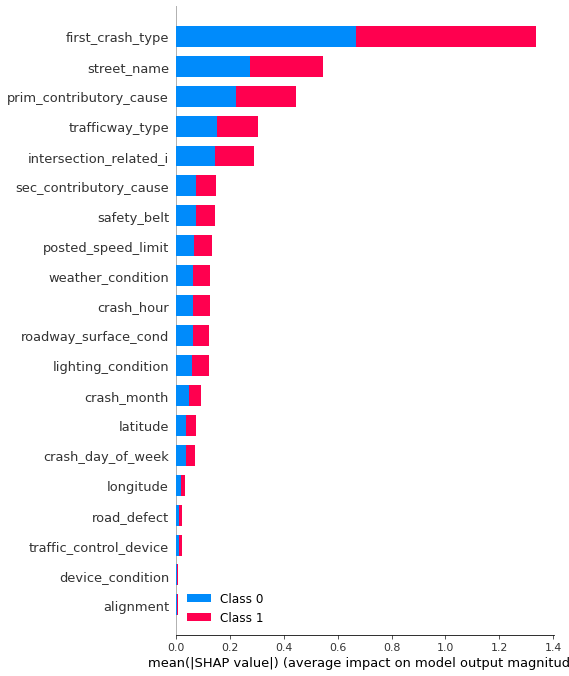

In [0]:
try:
  explainer = shap.TreeExplainer(
    model,
    #X_train.sample(1000),
    feature_perturbation='interventional',
    model_output='raw'
  )
  shap_values_interv  = explainer.shap_values(X_val.sample(1000))
  shap.summary_plot(shap_values_interv , X_val.sample(1000))
except Exception as e:
  print(e)

In [0]:
# does this feature make sense? continue investigation, apply skepticism!
X_train['first_crash_type'].value_counts()

Out[64]: PARKED MOTOR VEHICLE            28660
REAR END                        24345
SIDESWIPE SAME DIRECTION        17694
TURNING                         17518
ANGLE                           13682
FIXED OBJECT                     6026
PEDESTRIAN                       2740
REAR TO FRONT                    1809
PEDALCYCLIST                     1786
SIDESWIPE OPPOSITE DIRECTION     1498
OTHER OBJECT                     1274
HEAD ON                          1020
REAR TO SIDE                     1019
OTHER NONCOLLISION                375
REAR TO REAR                      365
OVERTURNED                         93
ANIMAL                             90
TRAIN                               6
Name: first_crash_type, dtype: int64